# Trying Torchvision *deeplabv3_resnet101* fine tunning with Fashionpedia

In [8]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import shutil

# -------------------- 1. Decodificar las máscaras RLE --------------------
def rle_decode(mask_rle, shape):
    ''' Convierte una máscara RLE en una matriz binaria '''
    s = np.fromstring(mask_rle, sep=' ', dtype=int)
    starts, lengths = s[::2] - 1, s[1::2]
    ends = starts + lengths
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    
    for start, end in zip(starts, ends):
        mask[start:end] = 1

    return mask.reshape(shape).T  # Devuelve en formato (alto, ancho)

# -------------------- 2. Cargar y preprocesar los datos --------------------
class FashionDataset(Dataset):
    def __init__(self, image_dir, annotations_df, transform=None):
        self.image_dir = image_dir
        self.annotations_df = annotations_df
        self.transform = transform

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        row = self.annotations_df.iloc[idx]
        image_id = row['ImageId']
        
        # Cargar la imagen
        image = cv2.imread(os.path.join(self.image_dir, f"{image_id}.jpg"))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB

        # Decodificar la máscara (RLE a binaria)
        if pd.notna(row['EncodedPixels']):
            mask = rle_decode(row['EncodedPixels'], image.shape[:2])
        else:
            mask = np.zeros(image.shape[:2], dtype=np.uint8)  # Sin máscara para esta imagen

        # Transformaciones (si es necesario)
        if self.transform:
            # Redimensionamos tanto la imagen como la máscara
            image, mask = self.transform(image, mask)

        return image, mask

# -------------------- 3. Transformaciones y preprocesamiento --------------------
def transform_image(image, mask, size=(256, 256)):  # Reducimos el tamaño de la imagen
    # Redimensionamos imagen y máscara
    image = cv2.resize(image, size)
    mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)  # Usar interpolación NEAREST para máscaras

    # Convertir la imagen a tensor
    image = transforms.ToTensor()(image)
    mask = torch.tensor(mask, dtype=torch.long)

    # Normalización de la imagen
    image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

    return image, mask

# ------------------ 4. Crear un subconjunto pequeño del dataset ------------------
# Establecer el número de imágenes que deseas usar (por ejemplo, 50)
num_images = 50

# Leer el archivo CSV con las anotaciones
train_df = pd.read_csv("imaterialist-fashion-2020-fgvc7/train.csv")

# Tomar las primeras `num_images` filas del dataframe (o cualquier subconjunto aleatorio)
subset_df = train_df.head(num_images)  # O usa .sample(n=num_images) para un subconjunto aleatorio

# Crear una nueva carpeta para almacenar el subconjunto de datos
subset_image_dir = "imaterialist-fashion-2020-fgvc7/train_subset"
if not os.path.exists(subset_image_dir):
    os.makedirs(subset_image_dir)

# Copiar las imágenes seleccionadas al nuevo directorio
for image_id in subset_df['ImageId']:
    src_image_path = f"imaterialist-fashion-2020-fgvc7/train/{image_id}.jpg"
    dst_image_path = os.path.join(subset_image_dir, f"{image_id}.jpg")
    shutil.copy(src_image_path, dst_image_path)

# ------------------ 5. Guardar el subconjunto de anotaciones ------------------
# Filtramos el dataframe original para incluir solo las imágenes seleccionadas
subset_df.to_csv(os.path.join(subset_image_dir, "train_subset.csv"), index=False)

# -------------------- 6. Preparación del modelo --------------------
# Cargar DeepLabV3 preentrenado en COCO
model = models.segmentation.deeplabv3_resnet101(pretrained=True)

# Modificar la capa final para el número de clases del dataset
num_classes = len(subset_df['ClassId'].unique())  # Número de clases únicas
in_channels = model.classifier[4].in_channels  # Número de canales de entrada de la última capa

# Nueva capa para las clases de tu dataset
model.classifier[4] = nn.Conv2d(in_channels, num_classes, kernel_size=(1, 1))

# Mover el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# -------------------- 7. Configuración del optimizador y función de pérdida --------------------
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# -------------------- 8. Cargar las anotaciones del subconjunto --------------------
train_subset_df = pd.read_csv(os.path.join(subset_image_dir, "train_subset.csv"))

# Crear DataLoader con el subconjunto de datos
train_subset_loader = DataLoader(FashionDataset(subset_image_dir, train_subset_df, transform=transform_image), batch_size=2, shuffle=True)  # Reducimos el batch size a 2

# -------------------- 9. Entrenamiento del modelo --------------------
num_epochs = 10  # Ajusta según tus necesidades

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_subset_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)["out"]

        # Pérdida y retropropagación
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss / 10}")
            running_loss = 0.0

print("Entrenamiento finalizado.")


/home/xoel/.local/share/virtualenvs/hackudc25-eJ45k4Db/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xoel/.local/share/virtualenvs/hackudc25-eJ45k4Db/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Batch 10, Loss: 2.8251917362213135
Epoch 1, Batch 20, Loss: 2.6576058626174928
Epoch 2, Batch 10, Loss: 2.4001397371292112
Epoch 2, Batch 20, Loss: 2.2412115812301634
Epoch 3, Batch 10, Loss: 2.0255019664764404
Epoch 3, Batch 20, Loss: 1.911453080177307
Epoch 4, Batch 10, Loss: 1.7258230447769165
Epoch 4, Batch 20, Loss: 1.656745159626007
Epoch 5, Batch 10, Loss: 1.4925208926200866
Epoch 5, Batch 20, Loss: 1.4274902939796448
Epoch 6, Batch 10, Loss: 1.2976837515830995
Epoch 6, Batch 20, Loss: 1.1849228143692017
Epoch 7, Batch 10, Loss: 1.089652383327484
Epoch 7, Batch 20, Loss: 1.0082814693450928
Epoch 8, Batch 10, Loss: 0.9280687987804412
Epoch 8, Batch 20, Loss: 0.8712430477142334
Epoch 9, Batch 10, Loss: 0.7934633553028106
Epoch 9, Batch 20, Loss: 0.7090603768825531
Epoch 10, Batch 10, Loss: 0.7088216483592987
Epoch 10, Batch 20, Loss: 0.6362831950187683
Entrenamiento finalizado.


### Prueba imágenes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


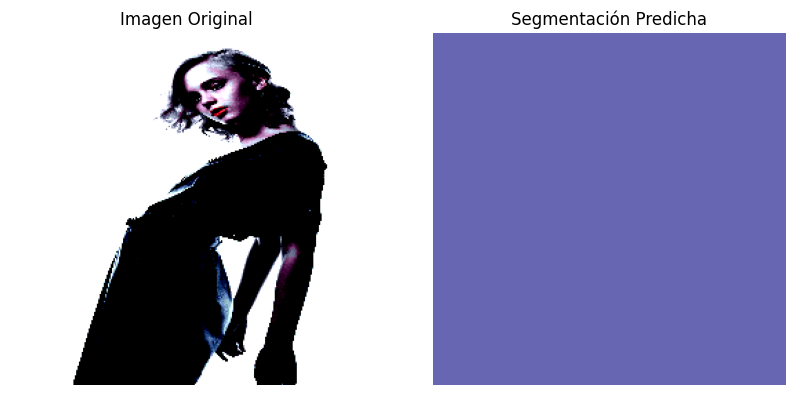

In [10]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision import transforms

# -------------------- 1. Función para realizar la segmentación en una imagen nueva --------------------
def segment_image(model, image_path, transform=None):
    # Cargar la imagen
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Aplicar las transformaciones necesarias
    if transform:
        image_rgb, _ = transform(image_rgb, np.zeros_like(image_rgb))  # No necesitamos la máscara aquí

    # Realizar la predicción
    model.eval()  # Modo evaluación
    with torch.no_grad():  # No calcular gradientes
        image_tensor = image_rgb.unsqueeze(0).to(device)  # Agregar la dimensión del batch
        output = model(image_tensor)["out"]  # Realizar el forward pass

    # Obtener la clase con mayor probabilidad (por cada píxel)
    pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()  # Eliminar la dimensión del batch

    return image_rgb, pred_mask

# -------------------- 2. Visualizar la imagen original y la máscara segmentada --------------------
def visualize_segmentation(original_image, mask):
    plt.figure(figsize=(10, 5))

    # Mostrar la imagen original (convertir la forma de (3, 256, 256) a (256, 256, 3))
    original_image = np.transpose(original_image, (1, 2, 0))  # Cambiar el orden de las dimensiones
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Imagen Original")
    plt.axis('off')

    # Mostrar la máscara segmentada
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='jet', alpha=0.6)  # Usar el mapa de colores 'jet' para la máscara
    plt.title("Segmentación Predicha")
    plt.axis('off')

    plt.show()

# -------------------- 3. Cargar y segmentar una imagen de prueba --------------------
# Seleccionamos una imagen aleatoria del directorio 'test'
test_image_dir = 'imaterialist-fashion-2020-fgvc7/test'
test_image_filename = os.listdir(test_image_dir)[6]  # Tomamos la primera imagen de la carpeta de test

test_image_path = os.path.join(test_image_dir, test_image_filename)  # Ruta completa a la imagen

# Segmenta la imagen usando el modelo entrenado
original_image, pred_mask = segment_image(model, test_image_path, transform=transform_image)

# Visualiza los resultados
visualize_segmentation(original_image, pred_mask)


### Descriptivo

In [2]:
# Establecer el número de imágenes que deseas usar (por ejemplo, 50)
num_images = 50

# Leer el archivo CSV con las anotaciones
train_df = pd.read_csv("imaterialist-fashion-2020-fgvc7/train.csv")

# Tomar las primeras `num_images` filas del dataframe (o cualquier subconjunto aleatorio)
subset_df = train_df.head(num_images)  # O usa .sample(n=num_images) para un subconjunto aleatorio

subset_df

,ImageId,EncodedPixels,Height,Width,ClassId,AttributesIds
0,00000663ed1ff0c4e0132b9b9ac53f6e,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,"115,136,143,154,230,295,316,317"
1,00000663ed1ff0c4e0132b9b9ac53f6e,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,"115,136,142,146,225,295,316,317"
2,00000663ed1ff0c4e0132b9b9ac53f6e,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,163
3,00000663ed1ff0c4e0132b9b9ac53f6e,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,"160,204"
4,00000663ed1ff0c4e0132b9b9ac53f6e,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,219
5,00000663ed1ff0c4e0132b9b9ac53f6e,11464158 10 11469372 30 11474586 43 11479800 4...,5214,3676,32,219
6,00000663ed1ff0c4e0132b9b9ac53f6e,5910568 31 5915775 65 5920982 69 5926189 73 59...,5214,3676,31,"160,204"
7,00000663ed1ff0c4e0132b9b9ac53f6e,6421446 292 6426657 298 6431867 305 6437078 31...,5214,3676,29,174
8,00000663ed1ff0c4e0132b9b9ac53f6e,4566382 8 4571592 25 4576803 41 4582013 58 458...,5214,3676,4,"17,115,136,145,149,225,295,311,317"
9,0000fe7c9191fba733c8a69cfaf962b7,2201176 1 2203623 3 2206071 5 2208518 8 221096...,2448,2448,33,190


# Mediapipe Mockup

In [ ]:
import cv2
import numpy as np
import requests
import mediapipe as mp
from mediapipe.tasks.python import vision
from mediapipe.tasks import python
from mediapipe.framework.formats import landmark_pb2

# Descargar el modelo PoseLandmarker
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

# Cargar el modelo PoseLandmarker de Mediapipe
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(base_options=base_options, output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# Función para descargar la imagen desde la URL
def download_image(url):
    img_array = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
    return cv2.imdecode(img_array, -1)

# Función para extraer una región de la imagen
def extract_region(image, landmarks, region_points, margin=80):
    # Obtener las coordenadas (x, y) de los puntos clave
    x_coords = [int(landmarks[point].x * image.shape[1]) for point in region_points]
    y_coords = [int(landmarks[point].y * image.shape[0]) for point in region_points]
    
    # Calcular los límites de la región con margen
    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)
    
    # Añadir margen a los límites
    min_x = max(min_x - margin, 0)  # Asegurarse de que no sea negativo
    max_x = min(max_x + margin, image.shape[1])
    min_y = max(min_y - margin, 0)  # Asegurarse de que no sea negativo
    max_y = min(max_y + margin, image.shape[0])
    
    # Recortar la imagen utilizando esos nuevos límites
    region = image[min_y:max_y, min_x:max_x]
    return region

# Función para dibujar los landmarks en la imagen
def draw_landmarks_on_image(rgb_image, detection_result):
    pose_landmarks_list = detection_result.pose_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected poses to visualize.
    for idx in range(len(pose_landmarks_list)):
        pose_landmarks = pose_landmarks_list[idx]

        # Draw the pose landmarks.
        pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        pose_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
        ])
        mp.solutions.drawing_utils.draw_landmarks(
            annotated_image,
            pose_landmarks_proto,
            mp.solutions.pose.POSE_CONNECTIONS,
            mp.solutions.drawing_styles.get_default_pose_landmarks_style())
    return annotated_image

# Función principal para procesar la imagen desde una URL
def process_image_from_url(image_url):
    # Descargar la imagen desde la URL
    image = download_image(image_url)

    # Convertir la imagen para ser compatible con MediaPipe
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crear un objeto Image desde OpenCV
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)

    # Detectar los landmarks de la pose
    results = detector.detect(mp_image)

    # Si no se detectaron landmarks, retornamos un mensaje
    if not results.pose_landmarks:
        print("No se detectaron landmarks en la imagen.")
        return None

    # Puntos clave para diferentes regiones del cuerpo
    head_points = [1, 2, 3, 4, 5]   # Puntos correspondientes a la cabeza
    torso_points = [12, 13, 14, 15]    # Puntos correspondientes al torso
    legs_points = [17, 18, 19, 20]  # Puntos correspondientes a las piernas
    feet_points = [28, 29, 30, 31]      # Puntos correspondientes a los pies

    # Extraer las diferentes regiones de la imagen
    head_image = extract_region(image, results.pose_landmarks[0], head_points)
    torso_image = extract_region(image, results.pose_landmarks[0], torso_points)
    legs_image = extract_region(image, results.pose_landmarks[0], legs_points)
    feet_image = extract_region(image, results.pose_landmarks[0], feet_points)

    # Retornar las imágenes extraídas
    return head_image, torso_image, legs_image, feet_image

# Ejemplo de uso con una URL
image_url = "https://cdn.pixabay.com/photo/2020/09/27/03/38/woman-5605529_640.jpg"
head_image, torso_image, legs_image, feet_image = process_image_from_url(image_url)

# Mostrar las imágenes extraídas
# Mostrar las imágenes extraídas
cv2.imshow("Head Image", head_image)
cv2.imshow("Torso Image", torso_image)
cv2.imshow("Legs Image", legs_image)
cv2.imshow("Feet Image", feet_image)

cv2.waitKey(5000)
cv2.destroyAllWindows()

I0000 00:00:1740244300.684234   78552 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1740244300.691762   79593 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.3.4-arch1.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1740244300.782027   79595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1740244300.824863   79604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


# MediaPipe *PoseLandmarker* Gemini final

In [24]:
import cv2
import numpy as np
import requests
import mediapipe as mp
from mediapipe.tasks.python import vision
from mediapipe.tasks import python
from mediapipe.framework.formats import landmark_pb2

# Descargar el modelo PoseLandmarker
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

# Cargar el modelo PoseLandmarker de Mediapipe
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(base_options=base_options, output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# Función para descargar la imagen desde la URL
def download_image(url):
    img_array = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
    return cv2.imdecode(img_array, -1)

# Función para calcular el factor de escala usando múltiples landmarks
def calculate_scale_factor(landmarks, image, scale_multiplier=1.5):
    # Calcular la distancia entre los hombros (puntos 11 y 12)
    shoulder_distance = np.linalg.norm(np.array([landmarks[14].x, landmarks[14].y]) - np.array([landmarks[15].x, landmarks[15].y]))
    
    # Calcular la distancia entre las caderas (puntos 23 y 24)
    hip_distance = np.linalg.norm(np.array([landmarks[18].x, landmarks[18].y]) - np.array([landmarks[19].x, landmarks[19].y]))
    
    # Calcular la distancia entre las rodillas (puntos 25 y 26)
    knee_distance = np.linalg.norm(np.array([landmarks[25].x, landmarks[25].y]) - np.array([landmarks[26].x, landmarks[26].y]))
    
    # Calcular la distancia entre los tobillos (puntos 27 y 28)
    ankle_distance = np.linalg.norm(np.array([landmarks[28].x, landmarks[29].y]) - np.array([landmarks[31].x, landmarks[31].y]))
    
    # Promediar las distancias calculadas para obtener un valor más robusto
    average_distance = np.mean([shoulder_distance, hip_distance, knee_distance, ankle_distance])
    
    # Definir una distancia estándar promedio (esto es una aproximación en píxeles)
    standard_average_distance = 200  # Estándar en píxeles (puedes ajustarlo según lo que consideres adecuado)
    
    # Calcular el factor de escala basado en la distancia promedio
    scale_factor = standard_average_distance / (average_distance * image.shape[1])  # Usamos el ancho de la imagen para la escala
    
    # Multiplicar por un factor adicional para ampliar la magnitud
    scale_factor *= scale_multiplier
    
    return scale_factor

# Función para extraer una región ajustada a la escala
def extract_scaled_region(image, landmarks, region_points, scale_factor, margin=80):
    # Obtener las coordenadas (x, y) de los puntos clave
    x_coords = [int(landmarks[point].x * image.shape[1]) for point in region_points]
    y_coords = [int(landmarks[point].y * image.shape[0]) for point in region_points]
    
    # Calcular los límites de la región
    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)
    
    # Ajustar los límites de la región con el margen
    min_x = max(min_x - margin, 0)  # Asegurarse de que no sea negativo
    max_x = min(max_x + margin, image.shape[1])
    min_y = max(min_y - margin, 0)  # Asegurarse de que no sea negativo
    max_y = min(max_y + margin, image.shape[0])

    # Escalar la región recortada de forma proporcional
    region = image[min_y:max_y, min_x:max_x]
    new_width = int(region.shape[1] * scale_factor)
    new_height = int(region.shape[0] * scale_factor)

    # Redimensionar la región a las nuevas dimensiones
    region_resized = cv2.resize(region, (new_width, new_height))
    
    return region_resized

# Función para procesar la imagen desde una URL
def process_image_from_url(image_url, scale_multiplier=1.5):
    # Descargar la imagen desde la URL
    image = download_image(image_url)

    # Convertir la imagen para ser compatible con MediaPipe
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Crear un objeto Image desde OpenCV
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)

    # Detectar los landmarks de la pose
    results = detector.detect(mp_image)

    # Si no se detectaron landmarks, retornamos un mensaje
    if not results.pose_landmarks:
        print("No se detectaron landmarks en la imagen.")
        return None

    # Calcular el factor de escala
    scale_factor = calculate_scale_factor(results.pose_landmarks[0], image, scale_multiplier)

    # Puntos clave para diferentes regiones del cuerpo
    head_points = [1, 2, 3, 4, 5]   # Puntos correspondientes a la cabeza
    torso_points = [12, 13, 14, 15]    # Puntos correspondientes al torso
    legs_points = [23, 24, 25, 26, 27, 28]  # Puntos correspondientes a las piernas
    feet_points = [28, 29, 30, 31]      # Puntos correspondientes a los pies

    # Extraer las diferentes regiones de la imagen ajustadas a la escala
    head_image = extract_scaled_region(image, results.pose_landmarks[0], head_points, scale_factor)
    torso_image = extract_scaled_region(image, results.pose_landmarks[0], torso_points, scale_factor)
    legs_image = extract_scaled_region(image, results.pose_landmarks[0], legs_points, scale_factor)
    feet_image = extract_scaled_region(image, results.pose_landmarks[0], feet_points, scale_factor)

    # Retornar las imágenes extraídas
    return head_image, torso_image, legs_image, feet_image

# Ejemplo de uso con una URL
image_url = "https://cdn.pixabay.com/photo/2019/03/12/20/39/girl-4051811_960_720.jpg"
# image_url = "https://cdn.pixabay.com/photo/2020/09/27/03/38/woman-5605529_640.jpg"
head_image, torso_image, legs_image, feet_image = process_image_from_url(image_url)


# image_demo1 = "https://images.unsplash.com/photo-1515886657613-9f3515b0c78f?q=80&w=1920&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D.jpg"
# head_image, torso_image, legs_image, feet_image = process_image_from_url(image_demo1)

# image_demo2 = "https://images.unsplash.com/photo-1520367745676-56196632073f?q=80&w=2127&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D.jpg"
# head_image, torso_image, legs_image, feet_image = process_image_from_url(image_demo2)

# Mostrar las imágenes extraídas
cv2.imshow("Head Image", head_image)
cv2.imshow("Torso Image", torso_image)
cv2.imshow("Legs Image", legs_image)
cv2.imshow("Feet Image", feet_image)

cv2.waitKey(20000)
cv2.destroyAllWindows()

I0000 00:00:1740246974.242399   82506 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1740246974.244145   84846 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.3.4-arch1.1), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1740246974.279589   84849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1740246974.320775   84848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
